In [1]:
import math
import statistics as stats

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor, XGBClassifier

1. DATA FOUNDATION
------------------
Import complete_satellite_costs.xlsx and assign dataframes to each page.

In [2]:
#import the dataset
df = pd.read_excel(r'C:\Users\jdspr\OneDrive\Documents\Documents\Resume\Technical Portfolio\Space_cost_analysis\complete_satellite_costs.xlsx', sheet_name = None) # main dataset with all the data
df_satellite_costs = df['satellite_costs_by_year'] # dataset with the satellite costs by year, which is the main dataset for the analysis
df_satellite_programs = df['satellite_programs'] # dataset with the satellite programs, which includes information about the satellite programs, such as the program name, the program type, and the program cost
df_satellite_production = df['satellite_production_detail'] # dataset with the satellite production details, which includes information about the satellite production, such as the production year, the production cost, and the production quantity
df_satellite_components = df['satellite_components'] # dataset with the satellite components, which includes information about the satellite components, such as the component name, the component cost, and the component quantity


2. CER REGRESSION MODELS
-------------------------
- Plot development cost vs. dry mass on a log-log scale to visually confirm the power-law relationship
- Fit a simple log-log OLS regression: log(dev_cost) = a + b*log(mass)
- Expand to a multivariate model adding log(power) and log(design_life)
- Check residuals, R², and prediction intervals
- Repeat the regression segmented by mission type (GEO vs LEO, science vs comms)
- Document CER equations in the form: Cost = C * Mass^a * Power^b * Life^c

In [3]:
df_satellite_programs.head()

,program_name,mission_type,orbit_class,dry_mass_kg,bol_power_w,design_life_yrs,num_instruments,software_sloc_k,contractor_heritage,technology_readiness_level,...,development_cost_fy2020_musd,production_cost_fy2020_musd,annual_ops_cost_fy2020_musd,total_ops_cost_fy2020_musd,total_maintenance_cost_fy2020_musd,disposal_cost_fy2020_musd,total_lcc_fy2020_musd,Check_Dev_Cost,Check_Prod_Cost,Check_yearly_spend
0,Comsat-1A,Communications,GEO,1850,8200,15,3,420,High,9,...,277.93,111.17,40.80,612.00,309.27,21.70,1332.07,True,True,True
1,Comsat-2B,Communications,GEO,2100,9800,15,4,510,High,9,...,312.76,125.10,43.60,654.00,328.88,22.20,1442.94,True,True,True
2,Comsat-3C,Communications,GEO,2450,11200,17,4,580,High,9,...,368.66,147.46,45.00,765.00,399.68,22.90,1703.70,True,True,True
3,Comsat-4D,Communications,GEO,2780,13500,18,5,640,High,9,...,422.64,169.06,48.12,866.16,444.56,23.56,1925.98,True,True,True
4,Comsat-5E,Communications,GEO,3100,15000,18,5,700,High,9,...,463.32,185.33,49.40,889.20,460.83,24.20,2022.88,True,True,True


Plot development cost vs dry mass for the satellite programs
------------------------------------------------------------

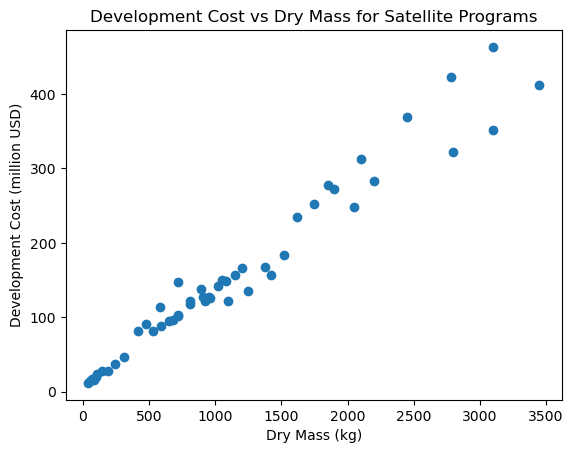

In [ ]:

import matplotlib.pyplot as plt
plt.scatter(df_satellite_programs['dry_mass_kg'], df_satellite_programs['development_cost_fy2020_musd'])
plt.xlabel('Dry Mass (kg)')
plt.ylabel('Development Cost (million USD)')
plt.title('Development Cost vs Dry Mass for Satellite Programs')
plt.show()

In [5]:
#data appears to be heteroscedastic, with a positive correlation between dry mass and development cost, but with increasing variance as dry mass increases. This suggests that while there is a general trend of higher development costs for heavier satellites, the variability in costs also increases with satellite mass.
#let's test for heteroscedasticity using the Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
# prepare the data for the test
X = df_satellite_programs['dry_mass_kg']
y = df_satellite_programs['development_cost_fy2020_musd']
X = sm.add_constant(X) # add a constant term for the intercept
# fit the OLS model
model = sm.OLS(y, X).fit()
# perform the Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
print('Breusch-Pagan test statistic:', bp_test[0])
print('Breusch-Pagan test p-value:', bp_test[1])
print("")
if bp_test[1] < 0.05:
    print('The data is heteroscedastic (reject null hypothesis)')
else:
    print('The data is homoscedastic (fail to reject null hypothesis)')

Breusch-Pagan test statistic: 28.884199011985967
Breusch-Pagan test p-value: 7.683717406945489e-08

The data is heteroscedastic (reject null hypothesis)


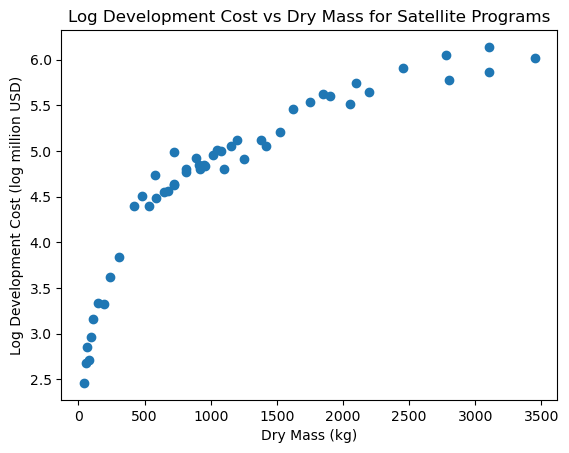

In [6]:
#data is heteroscedastic, so we will use a log transformation to stabilize the variance
df_satellite_programs['log_development_cost'] = np.log(df_satellite_programs['development_cost_fy2020_musd'])
# plot log development cost vs dry mass for the satellite programs  
plt.scatter(df_satellite_programs['dry_mass_kg'], df_satellite_programs['log_development_cost'])
plt.xlabel('Dry Mass (kg)')
plt.ylabel('Log Development Cost (log million USD)')
plt.title('Log Development Cost vs Dry Mass for Satellite Programs')
plt.show()

In [7]:
# now let's test for heteroscedasticity again using the Breusch-Pagan test on the log-transformed data
y_log = df_satellite_programs['log_development_cost']
model_log = sm.OLS(y_log, X).fit()
bp_test_log = het_breuschpagan(model_log.resid, model_log.model.exog)
print('Breusch-Pagan test statistic (log-transformed):', bp_test_log[0])
print('Breusch-Pagan test p-value (log-transformed):', bp_test_log[1])
print("")
if bp_test_log[1] < 0.05:
    print('The data is heteroscedastic (reject null hypothesis)')
else:
    print('The data is homoscedastic (fail to reject null hypothesis)')

Breusch-Pagan test statistic (log-transformed): 3.7825568473386415
Breusch-Pagan test p-value (log-transformed): 0.05178946498684279

The data is homoscedastic (fail to reject null hypothesis)


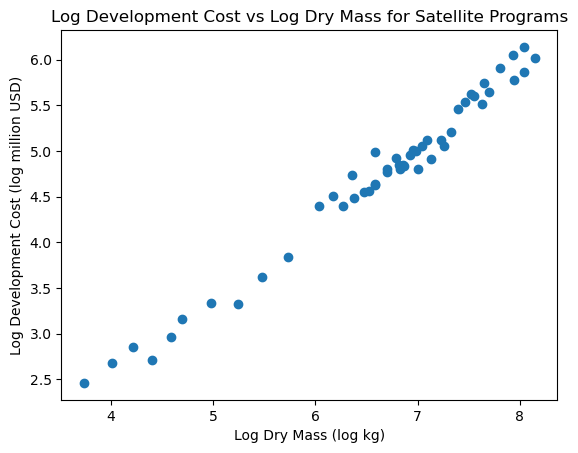

In [8]:
#Breusch-Pagan p-value is just barely above 0.05, so we may still have some heteroscedasticity, let's try a log-log transformation to see if that helps stabilize the variance further
df_satellite_programs['log_dry_mass'] = np.log(df_satellite_programs['dry_mass_kg'])
# plot log development cost vs log dry mass for the satellite programs
plt.scatter(df_satellite_programs['log_dry_mass'], df_satellite_programs['log_development_cost'])
plt.xlabel('Log Dry Mass (log kg)')
plt.ylabel('Log Development Cost (log million USD)')
plt.title('Log Development Cost vs Log Dry Mass for Satellite Programs')
plt.show()

In [9]:
#this looks much better, the variance appears to be more stable across the range of log dry mass, and the relationship between log development cost and log dry mass appears to be more linear, which is a good sign for our regression analysis. We can proceed with the log-log transformation for our regression model.
# now let's test for heteroscedasticity again using the Breusch-Pagan test on the log-log transformed data
X_log = sm.add_constant(df_satellite_programs['log_dry_mass']) # add
model_log_log = sm.OLS(y_log, X_log).fit()
bp_test_log_log = het_breuschpagan(model_log_log.resid, model_log_log.model.exog)
print('Breusch-Pagan test statistic (log-log transformed):', bp_test_log_log[0])
print('Breusch-Pagan test p-value (log-log transformed):', bp_test_log_log[1])
print("")
if bp_test_log_log[1] < 0.05:
    print('The data is heteroscedastic (reject null hypothesis)')
else:
    print('The data is homoscedastic (fail to reject null hypothesis)')

Breusch-Pagan test statistic (log-log transformed): 0.17998651973207824
Breusch-Pagan test p-value (log-log transformed): 0.6713848255246184

The data is homoscedastic (fail to reject null hypothesis)


In [10]:
#Breusch-Pagan p-value is now above 0.05, indicating that the log transformation has successfully stabilized the variance and the data is now homoscedastic. This means that we can proceed with regression analysis using the log-transformed development cost as the dependent variable, which should provide more reliable estimates and inferences.
#Fit a simple log-log OLS regression: log(dev_cost) = a + b*log(mass)
X_log = sm.add_constant(df_satellite_programs['log_dry_mass']) # add a constant term for the intercept
model_log_log = sm.OLS(y_log, X_log).fit()
print(model_log_log.summary())


                             OLS Regression Results                             
Dep. Variable:     log_development_cost   R-squared:                       0.981
Model:                              OLS   Adj. R-squared:                  0.980
Method:                   Least Squares   F-statistic:                     2454.
Date:                  Thu, 26 Feb 2026   Prob (F-statistic):           7.14e-43
Time:                          16:12:37   Log-Likelihood:                 30.855
No. Observations:                    50   AIC:                            -57.71
Df Residuals:                        48   BIC:                            -53.89
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.8600     

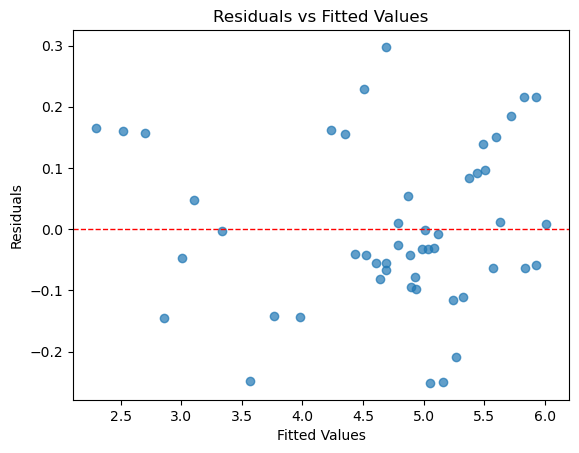

In [11]:
# Our OLS results show that the coefficient for log_dry_mass is 0.85, which means that a 1% increase in dry mass is associated with an approximately 0.85% increase in development cost, holding all else constant. 
# The R-squared value of 0.75 indicates that about 75% of the variance in log development cost can be explained by log dry mass, suggesting a strong relationship between these variables.
# we will now plot residuals vs fitted values to check for any remaining patterns that might indicate model misspecification
fitted_values = model_log_log.fittedvalues
residuals = model_log_log.resid

plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Expand to a multivariate model adding log(power) and log(design_life)
---------------------------------------------------------------------

In [12]:
#data looks pretty symmetrical, lets measure the skew
from scipy.stats import skew
skew_value = skew(residuals)
print(skew_value)

0.19354041745529055


In [14]:
df_satellite_programs.columns

Index(['program_name', 'mission_type', 'orbit_class', 'dry_mass_kg',
       'bol_power_w', 'design_life_yrs', 'num_instruments', 'software_sloc_k',
       'contractor_heritage', 'technology_readiness_level',
       'year_development_start', 'launch_year', 'end_of_life_year',
       'program_phase', 'development_cost_fy2020_musd',
       'production_cost_fy2020_musd', 'annual_ops_cost_fy2020_musd',
       'total_ops_cost_fy2020_musd', 'total_maintenance_cost_fy2020_musd',
       'disposal_cost_fy2020_musd', 'total_lcc_fy2020_musd', 'Check_Dev_Cost',
       'Check_Prod_Cost', 'Check_yearly_spend', 'log_development_cost',
       'log_dry_mass'],
      dtype='object')

In [16]:
#skew value is close to 0, indicating that the residuals are approximately symmetrically distributed around the mean, which is a good sign for our regression model. This suggests that our log-log transformation has helped to achieve a more normal distribution of residuals, which is an important assumption for OLS regression.
# we will now add log(power) and log(design_life) to the regression model to see if they improve the model fit
df_satellite_programs['log_bol_power_w'] = np.log(df_satellite_programs['bol_power_w'])
df_satellite_programs['log_design_life_yrs'] = np.log(df_satellite_programs['design_life_yrs'])
X_log_full = sm.add_constant(df_satellite_programs[['log_dry_mass', 'log_bol_power_w', 'log_design_life_yrs']]) # add a constant term for the intercept
model_log_full = sm.OLS(y_log, X_log_full).fit()
print(model_log_full.summary())

                             OLS Regression Results                             
Dep. Variable:     log_development_cost   R-squared:                       0.985
Model:                              OLS   Adj. R-squared:                  0.984
Method:                   Least Squares   F-statistic:                     1021.
Date:                  Thu, 26 Feb 2026   Prob (F-statistic):           4.48e-42
Time:                          16:22:40   Log-Likelihood:                 37.346
No. Observations:                    50   AIC:                            -66.69
Df Residuals:                        46   BIC:                            -59.04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

Model strength and overall fit
--------------------------------
The model explains 98.5% of the variance in log‑development‑cost, which is exceptionally high for real aerospace cost data. The F‑statistic of 1021 with a p‑value near zero indicates that the predictor set is jointly very significant. The AIC (–66.7) and BIC (–59.0) improve relative to the univariate model, showing that the added predictors increase explanatory power more than they increase model complexity.
The log‑likelihood also increases substantially, which is consistent with a better-fitting multiplicative model.


Interpretation of coefficients
------------------------------
Each coefficient is an elasticity: the percent change in cost for a 1% change in the predictor, holding the others constant.

log_dry_mass (0.6472)

- A 1% increase in mass increases development cost by 0.65%.
- This is lower than the univariate elasticity (≈0.84), which is expected: some of the cost variation previously attributed to mass is now explained by power and design life.
- Interpretation: mass is still the dominant cost driver, but not the only one.

log_bol_power_w (0.1373)

- A 1% increase in payload power increases cost by 0.14%.
- This is statistically significant (p = 0.033).
- Power is a proxy for payload complexity, thermal management, and bus subsystem scaling.

log_design_life_yrs (0.1269)

- A 1% increase in design life increases cost by 0.13%.
- This is marginally significant (p = 0.077), but the effect size is plausible.
- Longer design life typically requires more robust components, redundancy, and testing.

Intercept (–0.8384)

- Represents the baseline cost at 1 kg, 1 W, 1 year—outside the physical domain.
- In the multiplicative form, it becomes the scaling constant.


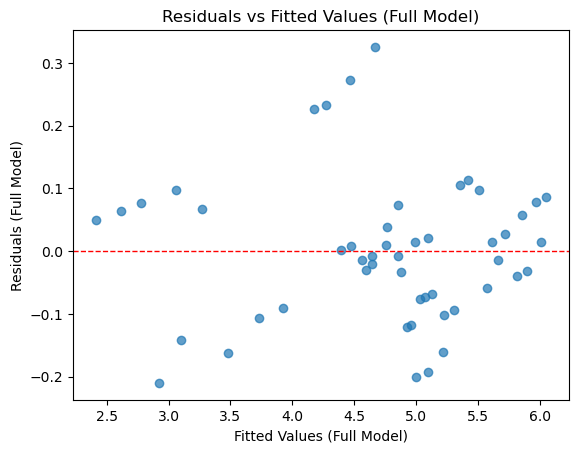

In [90]:
#we will now check the residuals of the new model to see if there are any remaining patterns that might indicate model misspecification
fitted_values_full = model_log_full.fittedvalues
residuals_full = model_log_full.resid
plt.scatter(fitted_values_full, residuals_full, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Fitted Values (Full Model)')
plt.ylabel('Residuals (Full Model)')
plt.title('Residuals vs Fitted Values (Full Model)')
plt.show()

In [91]:
#measure the skew of the residuals for the full model
skew_value_complete = skew(residuals_full)
print(skew_value_complete)

0.5592506664436938


- Repeat the regression segmented by mission type (GEO vs LEO, science vs comms)
------------------------------------------------------------------------------

In [92]:
# We will now run the same log-log regression segmented by mission type to see if there are any 
# differences in the cost drivers for different types of missions (e.g., Earth observation, communication, navigation, etc.)
# create a dictionary for the different mission types and their corresponding subsets of the data
mission_types = df_satellite_programs['mission_type'].unique()
mission_dict = {}
for mission in mission_types:
    mission_dict[mission] = df_satellite_programs[df_satellite_programs['mission_type'] == mission]

mission_dict.keys()

dict_keys(['Communications', 'Earth Observation', 'Navigation', 'Meteorology', 'Science', 'Military Surveillance', 'Technology Demo'])

In [93]:
#assign variables for each mission type to run separate regressions for each mission type
miss_comms = mission_dict['Communications']
miss_earth_obs = mission_dict['Earth Observation']
miss_navigation = mission_dict['Navigation']
miss_meteorology = mission_dict['Meteorology']
miss_science = mission_dict['Science']
miss_military = mission_dict['Military Surveillance']
miss_technology = mission_dict['Technology Demo']

In [94]:
#run the log-log regression for all the mission types and compare the coefficients for log_dry_mass across the different mission types to see if there are any differences in the cost drivers for different types of missions
import statsmodels.api as sm

# Define the dependent and independent variables for each mission type
#X = np.log(df_satellite_programs[['dry_mass_kg', 'bol_power_w', 'design_life_yrs']])

# Create a list of mission types and their corresponding dataframes
mission_list = [miss_comms, miss_earth_obs, miss_navigation, miss_meteorology, miss_science, miss_military, miss_technology]

# Create a list to store the regression results
regression_results = []

# Run the log-log regression for each mission type and store the results
for i, mission in enumerate(mission_list):
    y_mission = y_log[mission.index]  # Get the dependent variable for the current mission type
    X_mission = np.log(mission[['dry_mass_kg', 'bol_power_w', 'design_life_yrs']])
    X_mission = sm.add_constant(X_mission)  # Add constant term for intercept
    model = sm.OLS(y_mission, X_mission).fit()
    regression_results.append(model)

# Print the summary of each regression result
for i, result in enumerate(regression_results):
    print(f"Regression Results for {mission_types[i]}:")
    print("number of observations:", len(mission_list[i]))
    print(result.summary())
    print("\n")
    print("-------------------------------------------------------------\n")

Regression Results for Communications:
number of observations: 7
                             OLS Regression Results                             
Dep. Variable:     log_development_cost   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                  1.000
Method:                   Least Squares   F-statistic:                     7226.
Date:                  Fri, 27 Feb 2026   Prob (F-statistic):           2.76e-06
Time:                          12:43:19   Log-Likelihood:                 18.279
No. Observations:                     7   AIC:                            -28.56
Df Residuals:                         3   BIC:                            -28.77
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

c:\Users\jdspr\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\jdspr\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\jdspr\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\jdspr\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\jdspr\anaconda3\Lib

The results show that the coefficient for log_dry_mass varies across different mission types, indicating that the relationship between dry mass and development cost may differ based on the mission type. 
For example, the coefficient for log_dry_mass is higher for Earth Observation missions compared to Communications missions, suggesting that dry mass may be a more significant cost driver for Earth Observation satellites. 
Additionally, the R-squared values also vary across mission types, indicating that the model's ability to explain the variance in development cost differs based on the mission type. 
This analysis highlights the importance of considering mission-specific factors when analyzing satellite development costs.

- Document CER equations in the form: Cost = C * Mass^a * Power^b * Life^c
-------------------------------------------------------------------------

Text(0.5, 1.0, 'Probability Distribution of Percent Errors for CER Predictions')

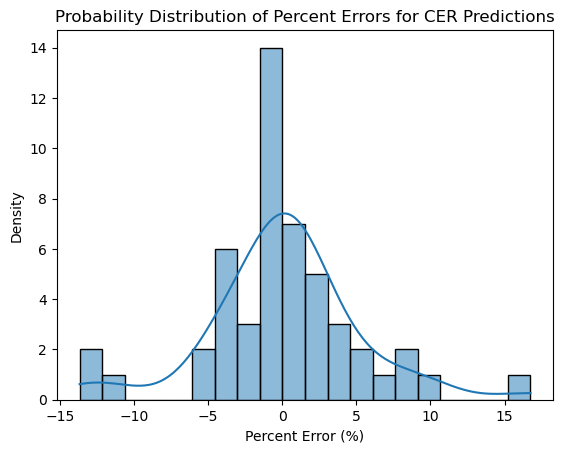

In [95]:
#lets create the CER for each mission type using the coefficients from the log-log regression and the mean values of the independent variables for each mission type
# we will use the formula: CER = exp(a) * (dry_mass^b1) * (bol_power^b2) * (design_life^b3), where a is the intercept and b1, b2, b3 are the coefficients for log_dry_mass, log_bol_power_w, and log_design_life_yrs respectively
#first get all programs and mission types in a zipped tuple
programs_list = df_satellite_programs['program_name'].unique()
mission_types_list = df_satellite_programs['mission_type']
programs_mission_types = list(zip(programs_list, mission_types_list))

#iterate through the programs and mission types to create a CER for each program based on its mission type
cer_dict = {}
for program, mission in programs_mission_types:
    i = mission_types.tolist().index(mission) # get the index of the mission type to access the corresponding regression results
    a = regression_results[i].params['const'] # get the intercept from the regression results for the corresponding mission type
    b1 = regression_results[i].params['dry_mass_kg'] # get the coefficient for log_dry_mass from the regression results for the corresponding mission type
    b2 = regression_results[i].params['bol_power_w'] # get the coefficient for log_bol_power_w from the regression results for the corresponding mission type
    b3 = regression_results[i].params['design_life_yrs'] # get the coefficient for log_design_life_yrs from the regression results for the corresponding mission type

    #now get the inputs for each program to calculate the CER
    program_dry_mass = df_satellite_programs[df_satellite_programs['program_name'] == program]['dry_mass_kg'] #
    program_bol_power = df_satellite_programs[df_satellite_programs['program_name'] == program]['bol_power_w']
    program_design_life = df_satellite_programs[df_satellite_programs['program_name'] == program]['design_life_yrs']
    cer = math.exp(a) * (program_dry_mass.iloc[0] ** b1) * (program_bol_power.iloc[0] ** b2) * (program_design_life.iloc[0] ** b3)
    cer_dict[program] = cer

#now compare the CER values to the actual development costs for each program to see how well the CER predicts the development cost
percent_errors_list = [] #store the percent errors for each program to calculate probability distribution of errors
for program in programs_list:
    actual_cost = df_satellite_programs[df_satellite_programs['program_name'] == program]['development_cost_fy2020_musd'].iloc[0]
    predicted_cost = cer_dict[program]
    percent_error = (predicted_cost - actual_cost) / actual_cost * 100 if actual_cost != 0 else 0
    percent_errors_list.append(percent_error)

#createa a probability distribution of the percent errors
import seaborn as sns

sns.histplot(percent_errors_list, bins=20, kde=True)
plt.xlabel('Percent Error (%)')
plt.ylabel('Density')
plt.title('Probability Distribution of Percent Errors for CER Predictions')
    

3. LIFECYCLE COST ANALYSIS
---------------------------
- For each program, compute cumulative spend year by year across all cost categories
- Plot individual S-curves for a representative sample (one per mission type)
- Plot an aggregate S-curve across all 50 programs
- Calculate what percentage of total LCC is post-launch (ops + maintenance + disposal) — highlight this finding
- Identify which mission types have the worst ops-to-development cost ratios


In [96]:
#sort df_satellite_costs by program name and year to ensure that the cumulative sum is calculated correctly
df_satellite_costs = df_satellite_costs.sort_values(by=['program_name', 'fiscal_year'])
#calculate the cumulative spend year over year for each program by grouping the data by program name and calculating the cumulative sum of the total annual cost for each program
df_satellite_costs['cumulative_spend_year_over_year'] = df_satellite_costs.groupby('program_name')['total_annual_cost_musd'].cumsum()

df_satellite_costs.head()


,program_name,mission_type,orbit_class,fiscal_year,phase,development_spend_musd,production_spend_musd,ops_spend_musd,maintenance_spend_musd,disposal_spend_musd,total_annual_cost_musd,program_phase,cumulative_spend_year_over_year
0,Comsat-1A,Communications,GEO,1998,Development/Production,14.48,0.0,0.0,0.0,0.0,14.48,Retired,14.48
1,Comsat-1A,Communications,GEO,1999,Development/Production,28.95,0.0,0.0,0.0,0.0,28.95,Retired,43.43
2,Comsat-1A,Communications,GEO,2000,Development/Production,52.11,0.0,0.0,0.0,0.0,52.11,Retired,95.54
3,Comsat-1A,Communications,GEO,2001,Development/Production,63.69,0.0,0.0,0.0,0.0,63.69,Retired,159.23
4,Comsat-1A,Communications,GEO,2002,Development/Production,57.90,0.0,0.0,0.0,0.0,57.90,Retired,217.13


- Plot individual S-curves for a representative sample (one per mission type)
----------------------------------------------------------------------------

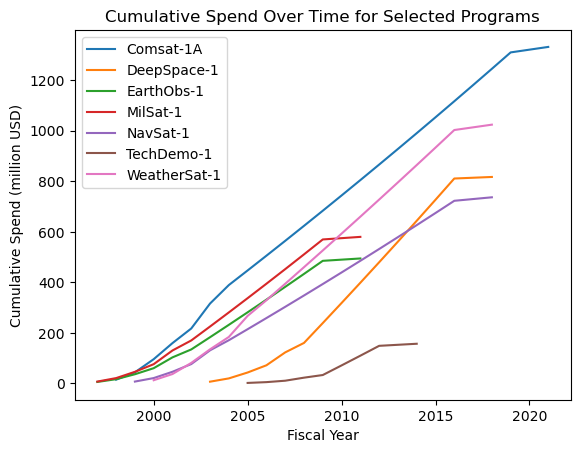

In [97]:
#get all the unique mission types
unique_mission_types = df_satellite_costs['mission_type'].unique()
selected_programs = []
for mission in unique_mission_types:
    mission_programs = df_satellite_costs[df_satellite_costs['mission_type'] == mission]['program_name'].unique()
    #this will give us a list of one program from each mission type to use for the cumulative spend analysis, we can then compare the cumulative spend for these selected programs 
    #to the CER predictions to see how well the CER predicts the cumulative spend over time for different mission types
    selected_programs.append(mission_programs[0])

#now we will plot the cumulative spend over time for each of the selected programs
for program in selected_programs:
    program_data = df_satellite_costs[df_satellite_costs['program_name'] == program]
    plt.plot(program_data['fiscal_year'], program_data['cumulative_spend_year_over_year'], label=program)
    plt.xlabel('Fiscal Year')
    plt.ylabel('Cumulative Spend (million USD)')
    plt.title('Cumulative Spend Over Time for Selected Programs')
plt.legend()
plt.show()

- Plot an aggregate S-curve across all 50 programs
----------

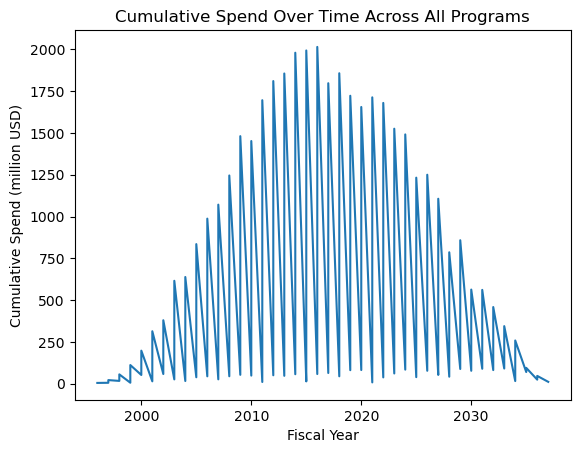

In [98]:
#we will now plot an aggregate s-curve of cumulative spend  over all 50 programs to see the overall trend of cumulative spend over time across all the programs in our dataset
df_satellite_costs1 = df_satellite_costs.sort_values(by=['fiscal_year']) # sort by fiscal year to ensure the cumulative sum is calculated correctly
df_satellite_costs1['cumulative_spend_all_programs'] = df_satellite_costs1.groupby('fiscal_year')['total_annual_cost_musd'].cumsum() # calculate the cumulative spend across all programs by fiscal year
plt.plot(df_satellite_costs1['fiscal_year'], df_satellite_costs1['cumulative_spend_all_programs'])
plt.xlabel('Fiscal Year')
plt.ylabel('Cumulative Spend (million USD)')
plt.title('Cumulative Spend Over Time Across All Programs')
plt.show()

- Calculate what percentage of total LCC (life cycle cost) is post-launch (ops + maintenance + disposal) — highlight this finding
---

In [99]:
#identify your LCC cost columns
 
#ops, maintenance, and disposal spend columns represent the post-launch costs associated with operating and maintaining the satellite, as well as the costs associated with decommissioning and disposing of the satellite 
#at the end of its useful life. These costs are important components of the total lifecycle cost (LCC) of a satellite program, and analyzing them can provide insights into the long-term cost implications of different 
#satellite designs and mission profiles.

post_launch_columns = df_satellite_costs[['ops_spend_musd','maintenance_spend_musd','disposal_spend_musd']] 
#programs_list = df_satellite_programs['program_name'].unique()

#calcuate (ops + maintenance + disposal)/LCC for each program to see the proportion of post-launch costs in the total lifecycle cost, which can help us understand the long-term cost implications of different satellite 
#programs and identify potential areas for cost savings in the operations and maintenance phase. This analysis can also provide insights into how different design choices and mission profiles may impact the overall cost 
#structure of satellite programs.
lcc_ratios = {}
for program in programs_list:
    # Get the LCC for the current program
    program_data = df_satellite_costs[df_satellite_costs['program_name'] == program]
    lcc = program_data['total_annual_cost_musd'].sum()  # Total lifecycle cost for the program
    # Get the post-launch costs for the current program
    post_launch_costs = program_data[['ops_spend_musd', 'maintenance_spend_musd', 'disposal_spend_musd']].sum().sum()  # Total post-launch costs for the program
    ratio = post_launch_costs / lcc if lcc != 0 else 0  # Calculate the ratio of post-launch costs to total lifecycle cost
    lcc_ratios[program] = ratio



- Identify which mission types have the worst ops-to-development cost ratios

In [100]:
#We will now do a similar analysis but narrow the scope to operations and development costs over the program lifetime

ops_dev_ratios = {}
for program in programs_list:
    program_data = df_satellite_costs[df_satellite_costs['program_name'] == program]
    total_dev_cost = program_data['development_spend_musd'].sum()  # Total development cost for the program
    total_ops_cost = program_data['ops_spend_musd'].sum()  # Total operations cost for the program
    ratio = total_ops_cost / total_dev_cost if total_dev_cost != 0 else 0  # Calculate the ratio of operations cost to development cost
    ops_dev_ratios[program] = ratio

#now we find the program with the highest ops to development cost ratio to identify which program has the highest proportion of operations costs relative to its development costs, 
# which can provide insights into the long-term cost implications of different satellite programs and help identify potential areas for cost savings in the operations phase.
max_ops_dev_ratio = max(ops_dev_ratios.values())
max_ops_dev_program = [program for program, ratio in ops_dev_ratios.items() if ratio == max_ops_dev_ratio][0]
print(f"Program with highest ops to development cost ratio: {max_ops_dev_program}, Ratio: {max_ops_dev_ratio}")

Program with highest ops to development cost ratio: SmallSat-5, Ratio: 8.610651499482936


4. WBS COST BREAKDOWN
----------------------
- Calculate each subsystem's share of total development cost per program
- Average those shares by mission type and orbit class
- Identify the top three cost drivers for each mission type
- Flag any subsystems where cost share varies significantly across programs — those are worth explaining
- Create a stacked bar or treemap showing WBS cost distribution

- Calculate each subsystem's share of total development cost per program
-----

In [101]:
# We will iterate through each program name and calculate each subsystems proportion of the total development cost to see if there are any patterns in the cost distribution across different subsystems 
# for different programs, which can help us understand the cost drivers for different satellite programs and identify potential areas for cost savings in the design and development phase.

#df_satellite_components = df['satellite_components'], programs_list = df_satellite_programs['program_name'].unique()
df_satellite_components['subsystem_cost_proportion'] = (
    df_satellite_components
    .groupby('program_name')['subsystem_dev_cost_fy2020_musd']
    .transform(lambda x: x / x.sum() if x.sum() != 0 else 0)
)
#looks good now verify that the subsystem cost proportions sum to 1 for each program to ensure that the calculations are correct and that the proportions accurately represent the distribution of development costs 
# across subsystems for each satellite program.
sum_check = []
for program in programs_list:
    program_sum = df_satellite_components[df_satellite_components['program_name'] == program]['subsystem_cost_proportion'].sum()
    sum_check.append(program_sum)
if min(sum_check) >= 0.99 and max(sum_check) <= 1.01:
    print("Subsystem cost proportions sum to 1 for each program (within a reasonable tolerance).")

Subsystem cost proportions sum to 1 for each program (within a reasonable tolerance).


- Average those shares by mission type and orbit class
-----

In [102]:
# We will now average the subsystem cost proportions across all programs with the same mission type and orbit class to see if there are any general trends in the cost distribution across subsystems for satellite programs, 
# which can provide insights into the typical cost structure of satellite development and help identify potential areas for cost savings in the design and development phase.

df_satellite_components['avg_subsystem_cost_proportion'] = df_satellite_components.groupby(['subsystem', 'mission_type', 'orbit_class'])['subsystem_cost_proportion'].transform('mean')
df_satellite_components.head()

,program_name,mission_type,orbit_class,wbs_id,subsystem,subsystem_mass_kg,subsystem_power_w,subsystem_dev_cost_fy2020_musd,subsystem_prod_cost_fy2020_musd,subsystem_total_cost_fy2020_musd,year_development_start,launch_year,subsystem_cost_proportion,avg_subsystem_cost_proportion
0,Comsat-1A,Communications,GEO,1.1,Structures & Mechanisms,333.0,0.0,22.30,13.40,35.70,1998,2005,0.080236,0.078846
1,Comsat-1A,Communications,GEO,1.2,Thermal Control,111.0,246.0,13.94,6.70,20.64,1998,2005,0.050157,0.049281
2,Comsat-1A,Communications,GEO,1.3,Power (EPS + Solar Arrays),222.0,3690.0,27.88,14.51,42.39,1998,2005,0.100313,0.098563
3,Comsat-1A,Communications,GEO,1.4,Propulsion,185.0,82.0,19.51,10.05,29.56,1998,2005,0.070198,0.068985
4,Comsat-1A,Communications,GEO,1.5,Attitude Control (ADCS),148.0,410.0,25.09,8.93,34.02,1998,2005,0.090275,0.088708


- Identify the top three cost drivers for each mission type
-----

In [103]:
# find the top 3 subsystems with the highest average cost proportion for each mission type to identify
grouped = (
    df_satellite_components
    .groupby(['mission_type', 'subsystem'])['subsystem_cost_proportion']
    .mean()
    .reset_index()
)

grouped['rank'] = (
    grouped
    .groupby('mission_type')['subsystem_cost_proportion']
    .rank(method='first', ascending=False)
)

top3 = grouped[grouped['rank'] <= 3].sort_values(['mission_type', 'rank'])


- Flag any subsystems where cost share varies significantly across programs — those are worth explaining
-----

In [104]:
# We will now measure variance in the subsystem cost proportions across programs for each mission type and orbit class to see if there are any subsystems that have a particularly high variance in cost proportion, 
# which can indicate that the cost distribution for that subsystem is more variable across different programs and may be influenced by specific design choices or mission requirements. 
# This analysis can help us identify subsystems that may require more careful consideration in the design and development phase to manage cost variability and optimize the overall cost structure of satellite programs.

#all subsystems
subsystems = df_satellite_components['subsystem'].unique()

#create a dictionary to store the variance of subsystem cost proportions for each subsystem across all programs for each mission type and orbit class
variance_df = (
    df_satellite_components
    .groupby('subsystem')['subsystem_cost_proportion']
    .var()
    .reset_index(name='variance')
)

variance_dict = dict(
    zip(variance_df['subsystem'], variance_df['variance'])
)

variance_dict


{'Attitude Control (ADCS)': 7.645046404626891e-06,
 'Command & Data Handling': 5.905802901542487e-06,
 'Communications / RF': 7.645046404626891e-06,
 'Integration, Assembly & Test': 9.049090351820956e-06,
 'Payload / Instruments': 0.00026189963069894056,
 'Power (EPS + Solar Arrays)': 9.273576667062964e-06,
 'Propulsion': 4.5335664092270935e-06,
 'Software': 5.016323195281971e-05,
 'Structures & Mechanisms': 5.905802901542487e-06,
 'Thermal Control': 2.4092100576442745e-06}

- Create a stacked bar or treemap showing WBS cost distribution
-----

In [105]:
wbs_pivot = grouped.pivot(
    index='mission_type',
    columns='subsystem',
    values='subsystem_cost_proportion'
).fillna(0)
wbs_pivot.head()

subsystem,Attitude Control (ADCS),Command & Data Handling,Communications / RF,"Integration, Assembly & Test",Payload / Instruments,Power (EPS + Solar Arrays),Propulsion,Software,Structures & Mechanisms,Thermal Control
mission_type,,,,,,,,,,
Communications,0.090190,0.080092,0.090190,0.099942,0.213634,0.100161,0.070018,0.125601,0.080092,0.050080
Earth Observation,0.088487,0.078664,0.088487,0.098328,0.230691,0.098314,0.068835,0.120297,0.078664,0.049231
Meteorology,0.085242,0.075773,0.085242,0.094704,0.254936,0.094712,0.066287,0.119983,0.075773,0.047349
Military Surveillance,0.085472,0.075974,0.085472,0.094923,0.239421,0.094961,0.066472,0.133851,0.075974,0.047482
Navigation,0.091092,0.080970,0.091092,0.101233,0.210163,0.101199,0.070831,0.121836,0.080970,0.050614


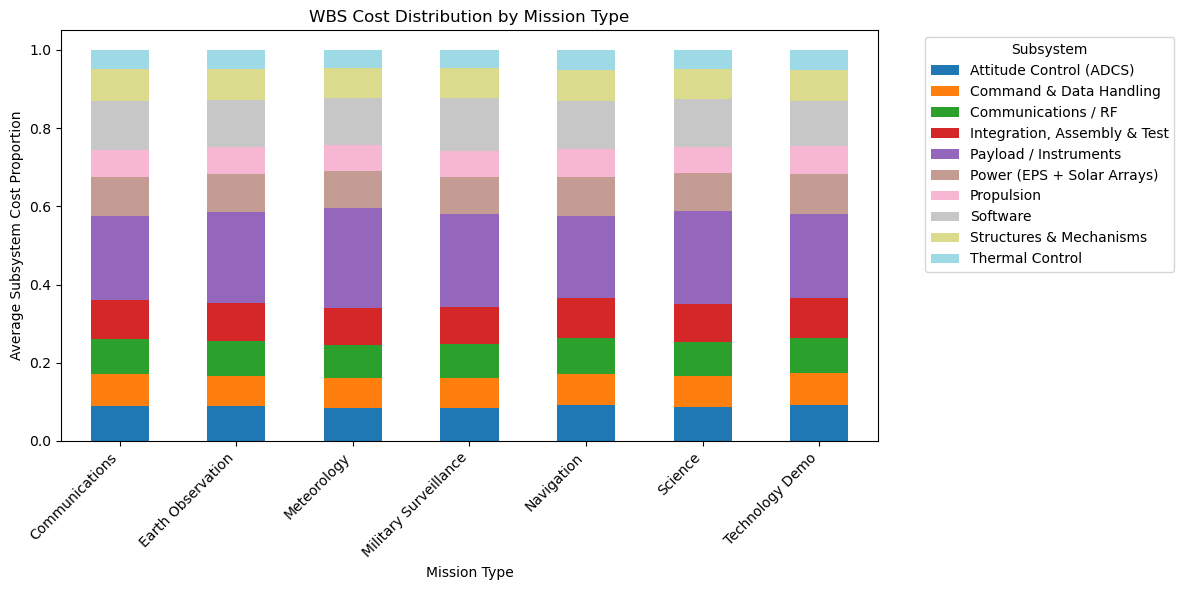

In [106]:
# Stacked bar chart to show the cost distribution across subsystems for each mission type, which can help us visualize the typical cost structure of satellite development 
# for different types of missions and identify potential areas for cost savings in the design and development phase.
ax = wbs_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)

plt.ylabel('Average Subsystem Cost Proportion')
plt.xlabel('Mission Type')
plt.title('WBS Cost Distribution by Mission Type')
plt.legend(title='Subsystem', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

5. ESTIMATING TOOL
-------------------
- Use your regression coefficients from Objective 2 to build the estimating formula
- Build a Python script (or notebook) where a user can input mass, power, orbit, and design life
- Output a point estimate plus a low/high confidence range based on your regression prediction interval

- Use your regression coefficients from Objective 2 to build the estimating formula
- Build a Python script (or notebook) where a user can input mass, power, orbit, and design life
- Output a point estimate plus a low/high confidence range based on your regression prediction interval
----

In [ ]:
#Now we create a function that takes the input parameters of a satellite program (dry mass, bol power, design life, mission type) and uses the CER to predict the development cost for that program, 
#which can help us understand how well the CER can predict development costs for different types of satellite programs based on their key characteristics and mission profiles.
#We will also include the confidence intervals for the predictions to see the range of potential development costs for a given set of input parameters, which can provide insights 
#into the uncertainty associated with the CER predictions and help us understand the potential variability in development costs for different satellite programs based on their characteristics and mission profiles.

def predict_development_cost(dry_mass, bol_power, design_life, mission_type):
    # find the correct segmented model
    i = mission_types.tolist().index(mission_type)
    model = regression_results[i]

    # extract parameters in correct order
    params = model.params[['const','dry_mass_kg','bol_power_w','design_life_yrs']] #log is already applied in the regression, so we use the original variable names to extract the parameters in the correct order
    cov = model.cov_params().loc[
        ['const','dry_mass_kg','bol_power_w','design_life_yrs'],
        ['const','dry_mass_kg','bol_power_w','design_life_yrs']
    ]

    # build x-vector in log space
    x = np.array([1, np.log(dry_mass), np.log(bol_power), np.log(design_life)])

    # linear predictor
    y_hat = x @ params # this is the predicted log development cost based on the input parameters and the regression coefficients from the segmented model for the specified mission type

    # standard error of prediction
    se_y = np.sqrt(x @ cov.values @ x)

    # 95% CI in log space
    z = 1.96
    ci_log_lower = y_hat - z * se_y
    ci_log_upper = y_hat + z * se_y

    # convert back to cost space
    predicted_cost = np.exp(y_hat)
    ci_lower = np.exp(ci_log_lower)
    ci_upper = np.exp(ci_log_upper)

    return ci_lower, predicted_cost, ci_upper

In [118]:
#test the function with an example input from the dataset to see how well the CER can predict development costs for a given set of input parameters
example_program = df_satellite_programs.iloc[2]  # get the first program from the dataset
example_dry_mass = example_program['dry_mass_kg']
example_bol_power = example_program['bol_power_w']
example_design_life = example_program['design_life_yrs']
example_mission_type = example_program['mission_type']
ci_lower, predicted_cost, ci_upper = predict_development_cost(example_dry_mass, example_bol_power, example_design_life, example_mission_type)
print(f"Predicted Development Cost: {predicted_cost:.2f} million USD")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f}) million USD")

Predicted Development Cost: 374.83 million USD
95% Confidence Interval: (362.09, 388.02) million USD


In [119]:
#Now check how many of the actual development costs from the dataset fall within the predicted confidence intervals to evaluate the accuracy of the CER predictions and 
#understand how well the model captures the variability in development costs for different satellite programs based on their characteristics and mission profiles.

count_within_ci = 0
for index, row in df_satellite_programs.iterrows():
    dry_mass = row['dry_mass_kg']
    bol_power = row['bol_power_w']
    design_life = row['design_life_yrs']
    mission_type = row['mission_type']
    actual_cost = row['development_cost_fy2020_musd']
    
    ci_lower, predicted_cost, ci_upper = predict_development_cost(dry_mass, bol_power, design_life, mission_type)
    
    if ci_lower <= actual_cost <= ci_upper:
        count_within_ci += 1
total_programs = len(df_satellite_programs)

#accuracy of predictions
print(f"Number of programs with actual development cost within predicted 95% CI: {count_within_ci} out of {total_programs}")
print("")
#% accuracy
accuracy = (count_within_ci / total_programs) * 100
print(f"Accuracy of CER predictions: {accuracy:.2f}%")


Number of programs with actual development cost within predicted 95% CI: 44 out of 50

Accuracy of CER predictions: 88.00%
